In [ ]:
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import collections  as mc
%matplotlib inline

import glob
import os
import pickle
import datetime
from scipy import stats

if "__file__" not in dir():
    %run loadRat_documentation.ipynb
    %run loadRawSpike_documentation.ipynb


    
# INFO: all the default parameters for preprocessing
defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

### Load Data
Load the preprocess data (corrected and binned position, speed, median position, ...)
 DEFAULT: load pickle if they exist, or create them
data=Data(root,animal,experiment,param=param)

 OPTION 1: do not save any new pickle file
data=Data(root,animal,experiment,param,saveAsPickle=False)

 OPTION 2: redo the preprocessing with param, even if the pickle already exist
 (to be sure everything is preprocess with the same parameters)

In [ ]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    root="/data"
    experiment="Rat121_2017_02_15_19_21"
    
    
    animal= experiment[:6]
    param={
        "goalTime":7,
        "treadmillRange":[0,90],
        "maxTrialDuration":60,
        "interTrialDuration":10,
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "binSize":0.25,
    }  
    data=Data(root,animal,experiment,param,redoPreprocess=True,saveAsPickle=False)
    print(data.hasBehavior)
    print(data.experiment)
    print(data.cameraSamplingRate)

In [ ]:
# Looking at different time axes attributes
if "__file__" not in dir():
    trial=50
    #plt.plot(data.rawTime[trial],data.rawPosition[trial],'b-')
    plt.plot(data.timeTreadmill[trial],data.position[trial],"g-")
    plt.plot(data.timeBin,data.positionBin[trial],'ro')#centered
    #plt.plot(data.lickTime[trial],np.zeros(len(data.lickTime[trial])),'mo')
    plt.ylabel("position(cm)")
    plt.xlabel("time(s)")
    plt.ylim(-5, 90)
    print()

### Display all attributes and their type  
Every attributes can be access with `data.attributeName`  

In [ ]:
#Description of the session parameters
if "__file__" not in dir():
    data.describe()
    print(data.emptyAnalysisFiles)

## Plot Behavioral data : TreadmillOn
###  Different position representations (trajectories of the animal)

In [ ]:
if "__file__" not in dir():
    trial=0
    plt.figure(figsize=(12,8))
    plt.subplot(325)
    for trial in data.trials:
        plt.plot(data.timeBin,data.positionBin[trial],'k-',alpha=0.2)
    plt.plot(data.timeBin,data.medianPosition,'r');
    plt.title("Median of corrected position");

    plt.subplot(322)
    plt.plot(data.timeBin,data.positionBin[trial],'bo-')
    plt.title("position smooth and binned for trial %s"%trial+'\n cut at the end of trial')
    plt.legend();
    
    plt.subplot(324)
    for trial in data.positionAlignEnd:
        plt.plot(data.timeAlignEnd,data.positionAlignEnd[trial],'k-',alpha=0.2)
    plt.title("Position align on end (%s)"%len(data.positionAlignEnd))
    
    plt.subplot(323)
    for trial in data.trials:
        plt.plot(data.timeBin,data.positionBin[trial],'k-',alpha=0.2)
    plt.title("Position align on treadmill start")
    
    plt.subplot(326)
    for trial in data.positionAlignEnd:
        plt.plot(data.timeAlignEnd,data.positionAlignEnd[trial],'k-',alpha=0.2)

    plt.plot(data.timeAlignEnd,data.medianPositionAlignEnd,'r')
    plt.title("median align on end")
    
    plt.subplot(321)
    trial=40
    plt.plot(data.timeTreadmill[trial],data.position[trial])
    plt.title("position(smooth, no bin), aligned on treadmill start")

### Positions, percentile, correlation

  - `onlyGood (False/True)`: plot/compute only on good trials
  - `raw (False/True)`: use raw positions. If False, use the corrected smoothed position.

In [99]:
def get_positions_array_beginning(data,onlyGood=False,raw=False):
    '''
    Return all the position in one array, between startFrame (treadmill start) and stopFrame (treadmill stop)
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    #the mean goal time, converted in number of frames    
    
    #put all positions in a 2D array
    allTraj=[]
    pos={}
    for trial in posDict:
        if onlyGood and (trial not in data.goodTrials):
            continue
        start = int(data.startFrame[trial])
        stop = int(data.stopFrame[trial])#endIndex#int(data.startFrame[trial]+size)
        pos[trial]=posDict[trial][start:stop]
    if len(pos)>0:
        size=np.max([len(pos[trial]) for trial in pos])

    for trial in pos:
        #pad with nan at the end if too short (entrance time < mean goal time)
        if len(pos[trial])<(size):
            pos[trial]=np.append(pos[trial],[np.nan] * (size-len(pos[trial])))
        allTraj.append(pos[trial])
    
    allTraj=np.asarray(allTraj)
    return allTraj

-0.00631004414799
-0.00673465483938


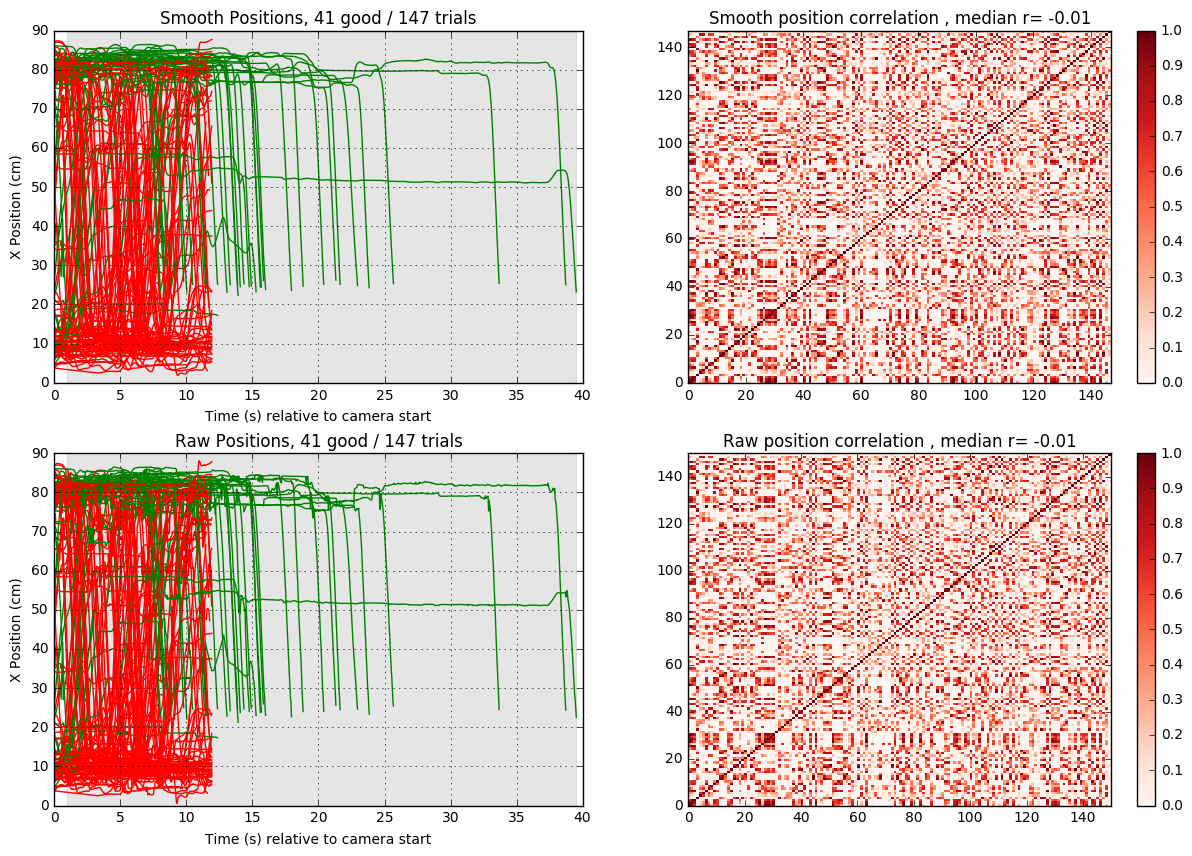

In [103]:

#----------------------------------------------------------------------------------------------------------------------
def plot_positions(data,onlyGood=False,raw=False):
    '''
    Plot the positions (green=good trial, red=other), aligned on camera start
    Plot the percentile (25%, 50%, 75%) on the beginning (trial start to trial stop (treadmill stop))
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    time=data.rawTime #align on camera
    
    for trial in posDict:
        color="green"
        if trial not in data.goodTrials:
            if onlyGood:
                continue
            color="red"

        plt.plot(time[trial][:data.stopFrame[trial]],posDict[trial][:data.stopFrame[trial]],color=color)
        
    #Get the positions between trial start and mean goal time
    allTraj=get_positions_array_beginning(data,onlyGood=onlyGood,raw=raw)
    #Check that the array is not empty
    if allTraj.shape[0]==0:
        if onlyGood:
            plt.title("0 Good trials")
        plt.title("No positions")
        return False

    #plot the percentiles
    #trajP=np.nanpercentile(allTraj,[25, 50, 75],axis=0)
    time=(np.arange(allTraj.shape[1])/data.cameraSamplingRate)+data.cameraToTreadmillDelay
    #plt.plot(time,trajP[0],"b--",lw=2)
    #plt.plot(time,trajP[1],"b-",lw=2)
    #plt.plot(time,trajP[2],"b--",lw=2)
    #title, labels, grid
    plt.ylabel("X Position (cm)")
    plt.xlabel("Time (s) relative to camera start")
    #plt.xlim([0,max(data.entranceTime)])
    #plt.xlim([0,16])
    plt.grid()
    plt.axvspan(time[0],time[-1],alpha=0.2,color="grey")
    title=""
    if raw:
        title="Raw "
    if not raw:
            title+="Smooth "
    if onlyGood:
        title+="Positions of %s good trials"%(len(data.goodTrials))
    else:
        title+="Positions, %s good / %s trials"%(len(data.goodTrials),len(data.trials))
    plt.title(title)
    
#----------------------------------------------------------------------------------------------------------------------
def plot_correlation_position(data,onlyGood=False,raw=False):
    '''
    Compute the correlation of the position between trial start and trial stop (treadmill stop)
    Plot the matrix of correlation coefficients
    Returns the median of coefficients
    '''
    import pandas as pd
    allTraj=get_positions_array_beginning(data,onlyGood=onlyGood,raw=raw)
    df = pd.DataFrame(allTraj.transpose())

    if allTraj.shape[0]<3:
        title="Not enough trials"
        med=np.nan
    else:
        corMatrix=np.array(df.corr())
        pp=plt.pcolor(corMatrix,vmin=0,vmax=1,cmap="Reds")
        plt.colorbar(pp)
        plt.xlim([0,corMatrix.shape[0]])
        plt.ylim([0,corMatrix.shape[1]])
        #median of upper triangle of matrix
        coef=corMatrix[np.triu_indices(corMatrix.shape[0],1)]
        med=np.nanmedian(coef)
        maxSecond=allTraj.shape[1]/float(data.cameraSamplingRate)
        #title of the plot
        title=""
        if onlyGood:
            title="Good "
        if raw:
            title+="Raw "
        if not raw:
            title+="Smooth "
    title+='position correlation , median r= %.2f'%med     
    plt.title(title)
    print(med)
    return med
     
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plot_positions(data,onlyGood=False)
    plt.subplot(222)
    plot_correlation_position(data,onlyGood=False,raw=False)
    plt.subplot(223)
    plot_positions(data,raw=True)
    plt.subplot(224)
    plot_correlation_position(data,onlyGood=False,raw=True)

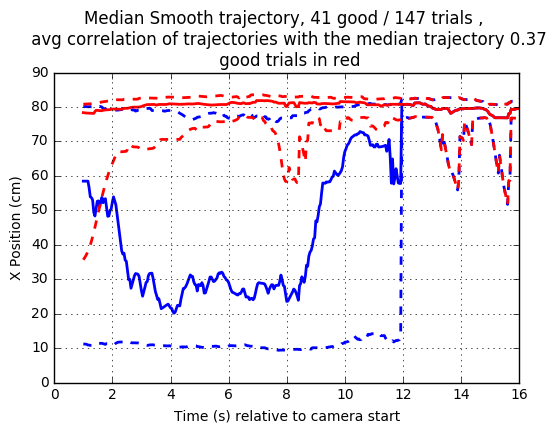

In [101]:
def plot_mediantrajectory(data,onlyGood=False,raw=False):
    '''
    Plot the positions (green=good trial, red=other), aligned on camera start
    Plot the percentile (25%, 50%, 75%) on the beginning (trial start to trial stop (treadmill stop))
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    time=data.rawTime #align on camera   
    #Get the positions between trial start and mean goal time
    allTraj=get_positions_array_beginning(data,onlyGood=onlyGood,raw=raw)
    #Check that the array is not empty
    if allTraj.shape[0]==0:
        if onlyGood:
            plt.title("0 Good trials")
        plt.title("No positions")
        return False

    #plot the percentiles
    trajP=np.nanpercentile(allTraj,[25, 50, 75],axis=0)
    corr=np.zeros( allTraj.shape[0])
    median=trajP[1]
    for trial in range(allTraj.shape[0]):
        traj=allTraj[trial,:]
        corr[trial]=scipy.stats.spearmanr(median[~np.isnan(traj)],traj[~np.isnan(traj)])[0]
    time=(np.arange(allTraj.shape[1])/data.cameraSamplingRate)+data.cameraToTreadmillDelay
    plt.plot(time,trajP[0],"b--",lw=2)
    plt.plot(time,trajP[1],"b-",lw=2)
    plt.plot(time,trajP[2],"b--",lw=2)
    
    #Get the positions between trial start and mean goal time for good trial only
    allTraj=get_positions_array_beginning(data,onlyGood=True,raw=raw)
    #Check that the array is not empty
    if allTraj.shape[0]==0:
        if onlyGood:
            plt.title("0 Good trials")
        plt.title("No positions")
        return False

    #plot the percentiles
    trajP=np.nanpercentile(allTraj,[25, 50, 75],axis=0)
    corr=np.zeros( allTraj.shape[0])
    median=trajP[1]
    for trial in range(allTraj.shape[0]):
        traj=allTraj[trial,:]
        corr[trial]=scipy.stats.spearmanr(median[~np.isnan(traj)],traj[~np.isnan(traj)])[0]
    time=(np.arange(allTraj.shape[1])/data.cameraSamplingRate)+data.cameraToTreadmillDelay
    plt.plot(time,trajP[0],"r--",lw=2)
    plt.plot(time,trajP[1],"r-",lw=2)
    plt.plot(time,trajP[2],"r--",lw=2)
    
    #title, labels, grid
    plt.ylabel("X Position (cm)")
    plt.xlabel("Time (s) relative to camera start")
    #plt.xlim([0,max(data.entranceTime)])
    plt.xlim([0,16])
    plt.grid()
    title=""
    if raw:
        title="Median Raw "
    if not raw:
            title+="Median Smooth "
    if onlyGood:
        title+="trajectory %s good trials"%(len(data.goodTrials))
    else:
        title+="trajectory, %s good / %s trials"%(len(data.goodTrials),len(data.trials))
    title+=' , \n avg correlation of trajectories with the median trajectory '+np.str(np.round(np.mean(corr),2))
    title+="\n good trials in red"
    plt.title(title)
    plt.ylim(0,90)
    return trajP
if "__file__" not in dir():
    plot_mediantrajectory(data,onlyGood=False)
    #plot_mediantrajectory(data,onlyGood=True)

### Position align on end and correlation

The end of each trial trajectory is detected during preprocessing with the parameters:

 - "endTrial_backPos":55,  minima is after the animal went once to the back (after first time position>backPos)
 - "endTrial_frontPos":30,  minima's position is in front of treadmill (position[end]\<frontPos)
 - "endTrial_minTimeSec":4, minima is after minTimeSec seconds (time[end]>minTimeSec)

The detection is done on the corrected smoothed position.  
`data.indexEndTrial` contains the detected index for each trial. If the end could not be detected, `indexEndTrial[trial]=None`.  
For more details see Preprocess_treadmillOn_detailed_documentation.ipnb

  - `minTime (int)`: time in seconds to consider, relative to detected end  
    `minTime= -5` means "keep 5 seconds before the end", for each trial
  - `onlyGood (True/False)`: whether to keep only good trials
  - `raw (True/False)`: whether to use raw positions

/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


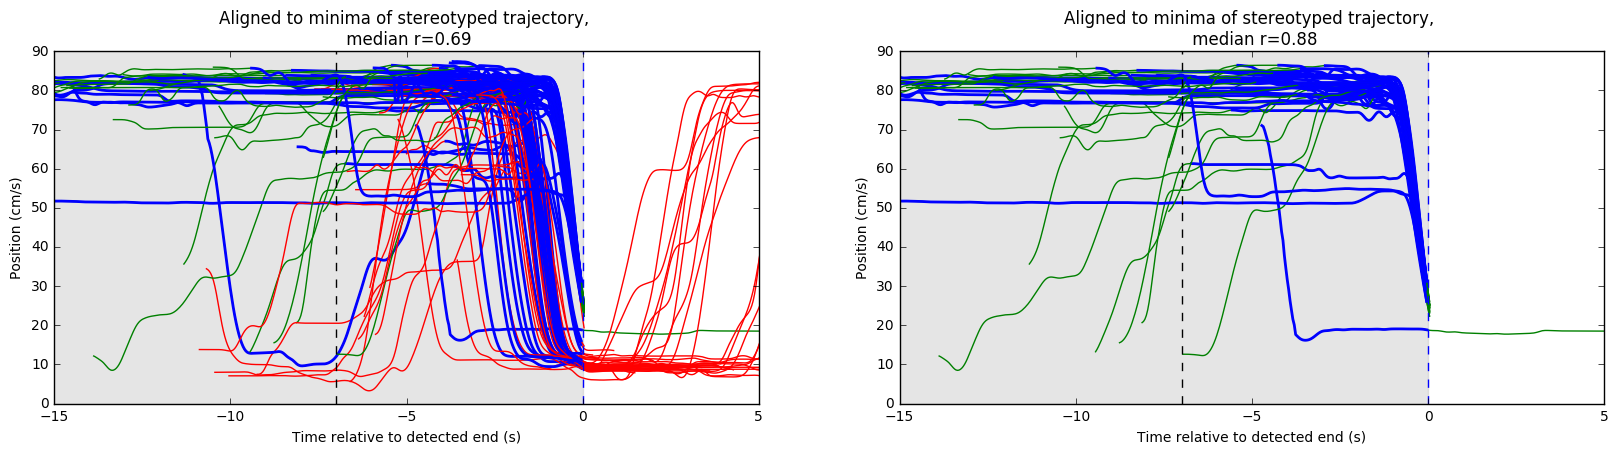

In [102]:
def get_positions_array_end_StereotypedTrials(data,onlyGood=False,raw=False):
    '''
    Returns array of position, align on detected end, between minTime and zero (0=end)
    The dectect end can be None, if so the trial is skipped
    If one position is too short (detected end is before minTime), 
      the position is pad at the beginning with nan values
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=np.max(data.maxTrialDuration)*cs#int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=[]
    for trial in posDict:
        if onlyGood and (trial not in data.goodTrials):
            continue
        #index where the steretyped trajectory ends
        endIndex=data.indexEndTrial[trial]
        if isNone(endIndex):
            #no end was detected, skipp trial
            continue 
        #Position is cut between (end -minTime) and end.
        #At minima, the cut should begin at startFrame
        startIndex=data.startFrame[trial]
        pos=posDict[trial][startIndex:endIndex]
       
        if len(pos)<(size):
            #pos=np.append([pos[0]] * (size-len(pos)),pos) #if too short, pad the start with a plateau (Nan would cause trouble to compute speed later)
            pos=np.append([np.nan] * (size-len(pos)),pos)
        allTraj.append(pos)
    allTraj=np.asarray(allTraj)
    return allTraj
#----------------------------------------------------------------------------------------------------------------------
def plot_position_align_end_StereotypedTrials(data,xUpLimit=5,onlyGood=False):
    '''
    [minTime to 0] is the time range to measure the correlation, with 0=detected end
    xUpLimit is the x axis max limit
    onlyGood is whether to consider only good trials
    nb: data.timeEndTrial is computed with data.position
    '''
    cs=data.cameraSamplingRate
    for trial in data.position:
        end=data.timeEndTrial[trial]
        stop=data.stopFrame[trial]
        start=data.startFrame[trial]#+data.cameraToTreadmillDelay*data.cameraSamplingRate
        indexStart=np.argmax(data.position[trial])
        indexEnd=data.indexEndTrial[trial]
        if isNone(end):
            continue
        color="green"
        if trial not in data.goodTrials:
            if onlyGood:
                continue
            color="red"
        plt.plot(data.timeTreadmill[trial][start:stop]-end,data.position[trial][start:stop],color=color)
        plt.plot(data.timeTreadmill[trial][indexStart:indexEnd]-end,data.position[trial][indexStart:indexEnd],color="b",lw=2)
    plt.xlim([-15,xUpLimit])
    plt.ylabel("Position (cm/s)")
    plt.xlabel("Time relative to detected end (s)")
    plt.axvline(0,color="b",ls="--")
    plt.axvline(-np.mean(data.goalTime),color="k",ls="--")
    w="correct " if onlyGood else ""
    
    allTraj=get_positions_array_end_StereotypedTrials(data,onlyGood=onlyGood,raw=False)
    df = pd.DataFrame(allTraj.transpose())
    if allTraj.shape[0]<3:
        title="Not enough trials"
        med=np.nan
    else:
        corMatrix=np.array(df.corr())
        coeff=corMatrix[np.triu_indices(corMatrix.shape[0],1)]
        med=np.nanmedian(coeff)
    plt.title("Aligned to minima of stereotyped trajectory, \n median r=%.2f" %(med))    
    plt.axvspan(-np.max(data.maxTrialDuration),0,alpha=0.2,color="grey")
    return med
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    #------------------------------------------------
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plot_position_align_end_StereotypedTrials(data,onlyGood=False)
    plt.subplot(222)
    plot_position_align_end_StereotypedTrials(data,onlyGood=True)

In [ ]:
if "__file__" not in dir():
    trial=22
    print(data.entranceTime[trial])
    plt.plot(data.timeTreadmill[trial],data.position[trial])
    plt.plot(data.timeTreadmill[trial][:data.stopFrame[trial]],data.position[trial][:data.stopFrame[trial]],'r')
    plt.axhline(data.position[trial][data.stopFrame[trial]-1])
    plt.axvline(data.entranceTime[trial])

In [ ]:
#----------------------------------------------------------------------
def get_positions_array_end_AllTrials(data,onlyGood=False,raw=False):
    '''
    Returns array of position, align on detected end, between minTime and zero (0=end)
    The dectect end can be None, if so the trial aligned to the treadmill stop time
    If one position is too short (detected end is before minTime), 
      the position is pad at the beginning with nan values
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=np.max(data.maxTrialDuration)*cs#int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=[]
    for trial in posDict:
        if onlyGood and (trial not in data.goodTrials):
            continue
        #index where the steretyped trajectory ends
        endIndex=data.indexEndTrial[trial]
        if isNone(endIndex):
            #no end was detected, take stop treadmill time
            endIndex=data.stopFrame[trial]

        #Position is cut between (end -minTime) and end.
        #At minima, the cut should begin at startFrame
        startIndex=data.startFrame[trial]
        pos=posDict[trial][startIndex:endIndex]
       
        if len(pos)<(size):
            #pos=np.append([pos[0]] * (size-len(pos)),pos) #if too short, pad the start with a plateau (Nan would cause trouble to compute speed later)
            pos=np.append([np.nan] * (size-len(pos)),pos)
        allTraj.append(pos)
    allTraj=np.asarray(allTraj)
    return allTraj
#---------------------------------------------------------------------------------------------------------------------
def plot_position_align_end_AllTrials(data,xUpLimit=5,onlyGood=False):
    '''
    xUpLimit is the x axis max limit
    onlyGood is whether to consider only good trials
    nb: data.timeEndTrial is computed with data.position
    '''
    cs=data.cameraSamplingRate
    for trial in data.position:
        end=data.timeEndTrial[trial]
        stop=data.stopFrame[trial]
        start=data.startFrame[trial]#+data.cameraToTreadmillDelay*data.cameraSamplingRate
        indexStart=np.argmax(data.position[trial])
        indexEnd=data.indexEndTrial[trial]
        if isNone(end):
            end=data.timeTreadmill[trial][data.stopFrame[trial]-1]
            indexEnd=data.stopFrame[trial]
        color="green"
        if trial not in data.goodTrials:
            if onlyGood:
                continue
            color="red"
        plt.plot(data.timeTreadmill[trial][start:stop]-end,data.position[trial][start:stop],color=color)
        plt.plot(data.timeTreadmill[trial][indexStart:indexEnd]-end,data.position[trial][indexStart:indexEnd],color="b",lw=2)
    plt.xlim([-15,xUpLimit])
    plt.ylabel("Position (cm/s)")
    plt.xlabel("Time relative to detected end (s)")
    plt.axvline(0,color="b",ls="--")
    plt.axvline(-np.mean(data.goalTime),color="k",ls="--")
    w="correct " if onlyGood else ""
    
    allTraj=get_positions_array_end_StereotypedTrials(data,onlyGood=onlyGood,raw=False)
    df = pd.DataFrame(allTraj.transpose())
    if allTraj.shape[0]<3:
        title="Not enough trials"
        med=np.nan
    else:
        corMatrix=np.array(df.corr())
        coeff=corMatrix[np.triu_indices(corMatrix.shape[0],1)]
        med=np.nanmedian(coeff)
    plt.title("Aligned to treadmill stop or minima of steretyped trajectory, \n median r=%.2f" %(med))    
    plt.axvspan(-np.max(data.maxTrialDuration),0,alpha=0.2,color="grey")
    return med

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plot_position_align_end_AllTrials(data,onlyGood=False)
    plt.subplot(222)
    plot_position_align_end_AllTrials(data,onlyGood=True)

### Speed

Treadmill speed has to taken into account to compute rat speed

` speed= treadmill speed - np.diff(position)*camera sampling rate `

positive speed= rat moving towards the front of the treadmill  
zero speed= rat not moving, dragged towards the end by the treadmill  
negative speed= rat moving towards the end, faster than the treadmill  

When the rat cross the beam, does the treadmill stop ? No it depends on its entrance time, the treadmill does not stop when the trial is bad (entrance time< goal time)

### Acceleration

` acceleration= np.diff(speed)*camera sampling rate `

In [ ]:
#---------------------------------------------------
def get_position_treadmillOn(data,trial):
    '''
    Compute position between treadmill start and treadmill stop, for one trial
    '''
    pos=data.position[trial]
    time=data.timeTreadmill[trial]
    start=data.startFrame[trial]   
    stoptime=time[-1]
    cs=data.cameraSamplingRate
    if data.entranceTime[trial]>=data.goalTime[trial]:
        stoptime = data.entranceTime[trial]
    stopList=np.where(time>=stoptime)[0]
    try:
        stop=stopList[0]
    except IndexError:
        stop=-1
    if data.dataType=="behav_param":
        stop=data.stopFrame[trial] 
    posCutted=pos[start:stop]
    timeCutted=time[start:stop]
    return posCutted,timeCutted
#---------------------------------------------------
def speed_from_pos(data,position,trial,sigmaSpeed=0.3):
    '''
    speed= (diff pos)* camera sampling rate -  treadmill speed 
    Speed can't be inferior to "- treadmill speed" (or even 0 ?)
    positive speed= rat moving towards the front of the treadmill
    negative speed= rat moving towards the end, faster than the treadmill
    '''
    cs=data.cameraSamplingRate
    tr=data.treadmillSpeed[trial]
    speed= tr - np.diff(position)*cs 
    speed[speed<(-tr)]=-tr
    speed=smooth(speed,sigmaSpeed*cs)
    return speed
#----------------------------------------------------------------------------------------------------------------------
def get_speed_treadmillON(data,trial,sigmaSpeed=0.3):
    '''
    Compute speed between treadmill start and treadmill stop, for one trial
    '''
    cs=data.cameraSamplingRate
    posCutted,timeCutted =  get_position_treadmillOn(data,trial)
    timeSpeed=(timeCutted[1:]+timeCutted[:-1])/2.0
    speed=speed_from_pos(data,posCutted,trial,sigmaSpeed)
    return speed,timeSpeed
#----------------------------------------------------------------------------------------------------------------------
def get_speed_end(data,trial,sigmaSpeed=0.3,minTime=-9):
    '''
    speed in the last 9 seconds (minTime=-9) (zero=detected end), for one trial
    '''
    cs=data.cameraSamplingRate
    endIndex=data.indexEndTrial[trial]
    if isNone(endIndex):
        return False, False
    pos=data.position[trial]
    cs=data.cameraSamplingRate
    startIndex=int(max(data.startFrame[trial],endIndex+(minTime*cs)))
    posCutted=pos[startIndex:endIndex]
    time=data.timeTreadmill[trial]-data.timeEndTrial[trial]
    timeCutted=time[startIndex:endIndex]
    timeSpeed=(timeCutted[1:]+timeCutted[:-1])/2.0
    speed=speed_from_pos(data,posCutted,trial,sigmaSpeed)
    return speed, timeSpeed
#----------------------------------------------------------------------------------------------------------------------
def plot_position_speed_acceleration(data,trial,sigmaSpeed=0.3):
    #plot position
    cs=data.cameraSamplingRate
    pos,time=get_position_treadmillOn(data,trial)
    plt.plot(time,pos,"k-",label="position")
    plt.ylabel("position (cm)")
    plt.xlabel("time (s)")
    # plot speed
   
    speed,timeSpeed=get_speed_treadmillON(data,trial,sigmaSpeed) 
    ax2=plt.gca().twinx()
    ax2.plot(timeSpeed,speed,color="red",label="speed")
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red') 
    ax2.set_ylabel("speed")
    plt.xlim([time[0],time[-1]])
    #plot acceleration
    timeAcceleration=timeSpeed[1:]
    cs=data.cameraSamplingRate
    acceleration= np.diff(speed)*cs
    ax2.plot(timeAcceleration,acceleration,color='blue',label="acceleration")
    
    #vertical and horizontal lines (treadmill speed, entrance time, startFrame)
    ax2.axhline(data.treadmillSpeed[trial],ls="--",color="g")
    ax2.axhline(0,ls="--",c="blue")
    ax2.axhline(-data.treadmillSpeed[trial],ls="--",color="g")
    plt.axvline(data.entranceTime[trial],color="purple")
    plt.axvline(data.maxTrialDuration[trial])
    plt.axvline(0,color="purple")

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    plt.figure(figsize=(10,5))
    trial =5
    plt.subplot(211)
    plt.title("kinematics with raw time binning calculated here")
    plot_position_speed_acceleration(data,trial,sigmaSpeed=0.3)
    plt.xlim(0,25)
    plt.subplot(212)
    plt.title("Binned kinematics based on the class attributes")
    plt.plot(data.timeBin,data.positionBin[trial],"ko-",label="position")
    plt.plot(data.timeBin,data.speedSmoothBin[trial],"ro-",label="speed")
    plt.plot(data.timeBin,data.accelerationOnSpeedSmoothBin[trial],"bo-",label="acceleration")
    plt.legend(loc="best")
    plt.xlim(0,25)

In [ ]:
def plot_kinematic_histo(data,kinematic="speedSmoothBin",binSize=1,title="Distribution of speed",xlablel="speed(cm/s)",color='b',alpha=1,onlyGood=False):
    k=np.asarray([])
    for trial in data.trials:
        if (not onlyGood) or (trial in data.goodTrials):
            k=np.append(k,data.__dict__[kinematic][trial])          
    #check that the vector is not empty
    if len(k)==0:
        return np.nan   
    #histogram between min and max speed, with binSize
    k=k[~np.isnan(k)]
    mink=np.nanmin(k)
    maxk=np.nanmax(k)
    hist,bins=np.histogram(k,np.arange(mink,maxk+1,binSize),density=True)
    #plot histograme
    centers=(bins[:-1]+bins[1:])/2.0
    plt.bar(centers,hist,width=binSize,color=color,alpha=alpha)
    #title, labels
    if onlyGood:
        title+=" - %s good trials"%(len(data.goodTrials))
    plt.title(title)
    plt.xlabel(xlablel+", binSize=%s"%binSize)
    plt.ylabel("Density")
    
    #vertical lines for 0 and treadmill speed
    plt.axvline(0,color="r",ls="--")
    if kinematic=="speedSmoothBin":
        plt.axvline(np.nanmean(data.treadmillSpeed),color="c",ls="--")
        #plt.xlim([-20,70])
    plt.ylim([0,0.14])
    return hist
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    hist=plot_kinematic_histo(data,kinematic="speedSmoothBin",title="Distribution of speed",xlablel="speed(cm/s)")
    plt.figure()
    hist=plot_kinematic_histo(data,kinematic="accelerationOnSpeedSmoothBin",title="Distribution of acceleration",xlablel="acceleration(cm/s²)")

In [ ]:
def plot_entrance_time(data,smoothSigma=2):
    #Get the entrance time for the correctly tracked trials
    entrance=[data.entranceTime[trial] for trial in data.trials]
    #Colors for good/bad trials
    colors=["green" if t in data.goodTrials else "red" for t in data.trials]
    #Scatter plot entrance time/ trial
    plt.scatter(data.realTrials,entrance,color=colors,marker="o")
    #Smooth line entrane time/ trial
    smoothEntrance=smooth(entrance,smoothSigma)
    plt.plot(data.realTrials,smoothEntrance,"b--",linewidth=2)
    #Horizontal line: maxTrial duration
    plt.plot(data.realTrials,[data.maxTrialDuration[t] for t in data.trials],"k--")
    #mean goal time
    goal=np.nanmean(data.goalTime)
    plt.axhspan(0,goal,alpha=0.2,color="grey")
    #limits, labels, title
    maxEntrance=max(goal,max(entrance))
    #plt.ylim([0,maxEntrance+1])
    plt.ylim([0,15])
    plt.xlim([0,data.nTrial+1])
    plt.grid()
    plt.ylabel('Entrance Time (s), mean goal=%s'%goal)
    plt.xlabel('Trial Number')
    plt.title("Entrance times, %s good trials"%(len(data.goodTrials)))

#----------------------------------------------------------------------------------------------------------------------
def plot_correlation_entrance_time(data,removeTimeout=False):    
    #entrance time with or without timeout
    if removeTimeout:
        entrance=[e for e,m in zip(data.entranceTime,data.maxTrialDuration) if e<m]
    else:
        entrance=data.entranceTime
    #remove nan/None
    entrance=[e for e in entrance if not isNone(e)]
    #check if not empty
    if not entrance:
        plt.title("No entrance times")
        return np.nan
    #plot entrance time n/entrance time n+1
    plt.plot(entrance[:-1],entrance[1:],"ko")
    plt.xlabel("Entrance time trial n")
    plt.ylabel("Entrance time trial n+1")
    #limits
    goal=np.nanmean(data.goalTime)
    m=max(goal,max(entrance))
    plt.ylim([0,m])
    plt.xlim([0,m])
    #diagonal and xspan
    plt.plot([0,m],[0,m],"k--")
    plt.axhspan(0,goal,alpha=0.2,color="grey")
    plt.axvspan(0,goal,alpha=0.2,color="grey")
    #spearman
    spearMan=scipy.stats.spearmanr(entrance[:-1],entrance[1:])
    if spearMan[1]<0.001:
        pvalue='p<0.001'
    else:
        pvalue='p= %.3f'%spearMan[1]
    plt.title("Correlation entrance times, Spearman r= %.2f, %s"%(spearMan[0],pvalue));  
    return spearMan[0]

#----------------------------------------------------------------------------------------------------------------------
def std_from_goaltime(data,removeTimeout=False):    
    #entrance time with or without timeout
    if removeTimeout:
        entrance=[e for e,m in zip(data.entranceTime,data.maxTrialDuration) if e<m]
    else:
        entrance=data.entranceTime
    #remove nan/None
    entrance=[e for e in entrance if not isNone(e)]
    #check if not empty
    if not entrance:
        return np.nan
    goal=np.nanmean(data.goalTime)
    #std from goal time
    ErrorStd=np.nanstd(np.abs(entrance-goal))
    print(ErrorStd)

    return ErrorStd
    
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    
    x=std_from_goaltime(data)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_entrance_time(data)
    plt.subplot(122)
    plot_correlation_entrance_time(data)
    #plt.xlim([0,25]),plt.ylim([0,25])

### General plot behavior

In [ ]:
def plot_session_behavior(data):
    fig=plt.figure(figsize=(20,15))
    
    plt.subplot(331)
    plot_positions(data)
    #plt.xlim(0,12)
    
    plt.subplot(337)
    plot_position_align_end_StereotypedTrials(data,onlyGood=False)
    
    plt.subplot(334)
    plot_position_align_end_AllTrials(data,onlyGood=False)
    
    
    plt.subplot(333)
    plot_correlation_position(data,onlyGood=False)

    plt.subplot(335)
    plot_entrance_time(data)
    plt.subplot(338)
    plot_correlation_entrance_time(data)
    
    plt.subplot(336)
    hist=plot_kinematic_histo(data,kinematic="speedSmoothBin",title="Distribution of speed",xlablel="speed(cm/s)",color='b',alpha=0.8)
    hist=plot_kinematic_histo(data,kinematic="speedSmoothBin",title="Distribution of speed",xlablel="speed(cm/s)",color='r',alpha=0.5,onlyGood=True)
    plt.title("Distribution of speed(blue:all trials, red: only good)")   
    plt.subplot(339)
    hist=plot_kinematic_histo(data,kinematic="accelerationOnSpeedSmoothBin",title="Distribution of acceleration",xlablel="acceleration(cm/s²)",alpha=0.8)
    hist=plot_kinematic_histo(data,kinematic="accelerationOnSpeedSmoothBin",title="Distribution of acceleration",xlablel="acceleration(cm/s²)",color='r',alpha=0.5,onlyGood=True)
    plt.title("Distribution of acceleration(blue:all trials, red: only good)")  
    plt.subplot(332)
    plot_mediantrajectory(data,onlyGood=False,raw=False)
    #plt.tight_layout()
    title=data.experiment+", day %s, %s trials"%(data.daySinceStart,data.nTrial)
    plt.suptitle(title,fontsize=16)
    fig.subplots_adjust(hspace=.5)
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():  
    plot_session_behavior(data)  
    
    #path=os.path.join(root,"Analysis")
    #pathFig=os.path.join(path,"Rat051_2016_05_06_16_04.png")
    #plt.savefig(pathFig)
    